In [25]:
import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)


Azure ML SDK Version:  1.3.0


In [2]:
!pip install --upgrade azureml-sdk

Requirement already up-to-date: azureml-sdk in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (1.3.0)


## Initialize workspace

In [26]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()

print(ws.name, ws.location, ws.resource_group, ws.location, sep='\t')


sandboxaml	westeurope	rg-sandbox	westeurope


## Create an experiment

In [27]:
experiment_name = 'diabetes_exp'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

exp


Name,Workspace,Report Page,Docs Page
diabetes_exp,sandboxaml,Link to Azure Machine Learning studio,Link to Documentation


## Upload dataset

In [28]:
from azureml.core import Dataset

dataset = Dataset.get_by_name(ws, name='diabetes')


In [29]:
diabetes = dataset.to_pandas_dataframe().drop("Path", axis=1)

In [30]:
diabetes.head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


In [32]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
AGE    442 non-null int64
SEX    442 non-null int64
BMI    442 non-null float64
BP     442 non-null float64
S1     442 non-null int64
S2     442 non-null float64
S3     442 non-null float64
S4     442 non-null float64
S5     442 non-null float64
S6     442 non-null int64
Y      442 non-null int64
dtypes: float64(6), int64(5)
memory usage: 38.1 KB


In [33]:
diabetes.describe()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.641411,91.260181,152.133484
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.522391,11.496335,77.093005
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000,25.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000,87.000000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000,140.500000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000,211.500000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000,346.000000


In [34]:
features_names = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
target = "Y"

## Train the model

In [35]:
# Separate train and test data

from sklearn.model_selection import train_test_split

X = diabetes.drop(target, axis=1)
y = diabetes["Y"].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [36]:
# There are three steps to model something with sklearn

from sklearn.linear_model import LinearRegression

# 1. Set up the model
model = LinearRegression()
# 2. Use fit
model.fit(X_train, y_train)
# 3. Check the score
model.score(X_test, y_test)


0.4526027629719189

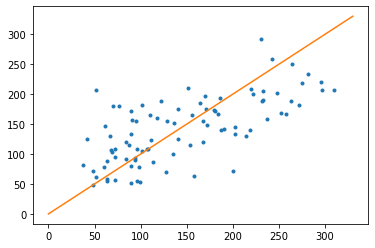

In [37]:
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline

# plot prediction and actual data
y_pred = model.predict(X_test) 
plt.plot(y_test, y_pred, '.')

# plot a line, a perfit predict would all fall on this line
x = np.linspace(0, 330, 100)
y = x
plt.plot(x, y)
plt.show()


In [38]:
from sklearn.externals import joblib
import pickle

os.makedirs('models', exist_ok=True)

# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=model, filename='models/diabetes_regression_model.pkl')


['models/diabetes_regression_model.pkl']

## Register the model

In [44]:
# sckit learn version
import sklearn
print(sklearn.__version__)

0.20.3


In [40]:
# Register the model (from the locally train)

from azureml.core.model import Model

model = Model.register(model_path="models/diabetes_regression_model.pkl",
                       model_name="diabetes_regression_model",
                       model_framework=Model.Framework.SCIKITLEARN,  # Framework used to create the model.
                       model_framework_version='0.20.3',             # Version of scikit-learn used to create the model.
                       tags={'area': "diabetes", 'type': "regression"},
                       description="Linear regression model to predict diabetes",
                       workspace=ws)


Registering model diabetes_regression_model


In [17]:
# load an existing model

from azureml.core.model import Model

model = Model(ws, "diabetes_regression_model")

print(model.id, model.name, model.version, sep='\t')


diabetes_regression_model:7	diabetes_regression_model	7


### Define model with input and output datasets

In [41]:
from azureml.core import Dataset

input_dataset = Dataset.get_by_name(ws, name='diabetes').drop_columns("y")
output_dataset = Dataset.get_by_name(ws, name='diabetes').keep_columns("y", validate=False)


In [19]:
# Register model with sample inpout and output

from azureml.core import Model
from azureml.core.resource_configuration import ResourceConfiguration

model = Model.register(workspace=ws,
                       model_name="diabetes_reg_model_wsample",                # Name of the registered model in your workspace.
                       model_path="models/diabetes_regression_model.pkl",      # Local file to upload and register as a model.
                       model_framework=Model.Framework.SCIKITLEARN,            # Framework used to create the model.
                       model_framework_version='0.20.3',                       # Version of scikit-learn used to create the model.
                       sample_input_dataset=input_dataset,
                       sample_output_dataset=output_dataset,
                       resource_configuration=ResourceConfiguration(cpu=1, memory_in_gb=0.5),
                       description='Linear regression model to predict diabetes progression.',
                       tags={'area': 'diabetes', 'type': 'regression'})

print('Name:', model.name)
print('Version:', model.version)


Registering model diabetes_reg_model_wsample
Name: diabetes_reg_model_wsample
Version: 5


In [20]:
# load an existing model

from azureml.core.model import Model

model = Model(ws, "diabetes_reg_model_wsample")


## Deploy in a default environment

The Azure Machine Learning service provides a default environment for supported model frameworks, including scikit-learn, based on the metadata you provided when registering your model. This is the easiest way to deploy your model.

Even when you deploy your model to ACI with a default environment you can still customize the deploy configuration (i.e. the number of cores and amount of memory made available for the deployment) using the AciWebservice.deploy_configuration(). Look at the "Use a custom environment" section of this notebook for more information on deploy configuration.

Note: This step can take several minutes.

In [42]:
# Use a default environment
# nécessite d'avoir précisé l'environnement lors de l'enregistrement du modèle
# Default environments are only provided for these frameworks: ['Onnx', 'ScikitLearn', 'TensorFlow']."

from azureml.core import Webservice
from azureml.exceptions import WebserviceException

service_name = 'diabetes-default-service'

# Remove any existing service under the same name.
try:
    Webservice(ws, service_name).delete()
except WebserviceException:
    pass

service = Model.deploy(ws, service_name, [model])
service.wait_for_deployment(show_output=True)


Running.......................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"


In [22]:
# reload the model

from azureml.core import Webservice

service_name = 'diabetes-default-service'
service = Webservice(ws, service_name)

print(service.name, service.scoring_uri, sep='\t')


diabetes-service	None


## Test the service

In [43]:
import json

input_payload = json.dumps({
    'data': [
        [59, 2, 32.1, 101.0, 157, 93.2, 38.0, 4.0, 4.8598, 87],
        [69, 2, 32.1, 101.0, 157, 93.2, 38.0, 4.0, 4.8598, 87]
    ],
    'method': 'predict'  # If you have a classification model, you can get probabilities by changing this to 'predict_proba'.
})

output = service.run(input_payload)

print(output)


{'predict': [[210.74209144739257], [212.1189695974167]]}


In [23]:
service.delete()
